# Augmentation with fixed normality

> Training a classifier that uses the same dataset as the DDPM models, with the same normalization routine

In [1]:
#| default_exp augmentation_norm

In [2]:
# |export
import torch
from torchvision import transforms

from slowai.learner import (
    DataLoaders,
    tensorize_images,
)
from slowai.augmentation import ResNetWithGlobalPoolingInitialConv, summarize, train

This dataloader code is copied from `13_ddpm`.

In [3]:
pipe = [
    transforms.Resize((32, 32)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Lambda(lambda x: x - 0.5),
]

In [4]:
def get_dls(bs=128):
    return tensorize_images(
        DataLoaders.from_hf("fashion_mnist", bs=bs),
        pipe=pipe,
        normalize=False,
    ).listify()

In [5]:
dls = get_dls()

In [6]:
xb, _ = dls.peek()
xb.min(), xb.max()

(tensor(-0.5000), tensor(0.5000))

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| Conv | (8, 1, 28, 28) | (8, 32, 28, 28) | 864 | 0.6
| ResidualConvBlock | (8, 32, 28, 28) | (8, 64, 14, 14) | 57,664 | 11.2
| ResidualConvBlock | (8, 64, 14, 14) | (8, 128, 7, 7) | 230,016 | 11.2
| ResidualConvBlock | (8, 128, 7, 7) | (8, 256, 4, 4) | 918,784 | 14.7
| ResidualConvBlock | (8, 256, 4, 4) | (8, 512, 2, 2) | 3,672,576 | 14.7
| ResidualConvBlock | (8, 512, 2, 2) | (8, 512, 1, 1) | 4,983,296 | 5.0
| Linear | (8, 512) | (8, 10) | 5,130 | 0.0
| BatchNorm1d | (8, 10) | (8, 10) | 20 | 0.0
| Total | | | 9,868,350 | |

MulticlassAccuracy,loss,epoch,train
0.866,0.557,0,train
0.859,0.429,0,eval
0.891,0.352,1,train
0.872,0.352,1,eval
0.903,0.282,2,train
0.887,0.313,2,eval
0.917,0.238,3,train
0.894,0.303,3,eval
0.928,0.204,4,train
0.891,0.321,4,eval


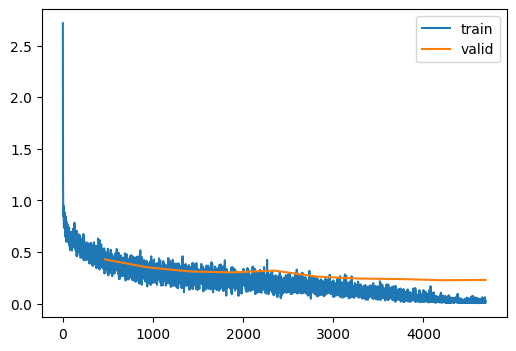

In [7]:
mz = ResNetWithGlobalPoolingInitialConv.kaiming(nfs=[32, 64, 128, 256, 512, 512])
summarize(mz, [*mz.layers, mz.lin, mz.norm])
train(mz, dls=dls, n_epochs=10)

In [8]:
# Save this for later
torch.save(mz, "../models/fashion_mnist_classifier.pt")